In [2]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, header="Embeddings with Glove")

In [3]:
import gensim
from gensim import corpora

import pandas as pd
import numpy as np


from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.base import get_data_home
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dropout

import os

import p9_util

extension=''

Using TensorFlow backend.
/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
W0820 00:49:32.533193 139907239372608 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0820 00:49:32.535860 139907239372608 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0820 00:4

## <font color=blus>1. Loading BOW dataset</font>

##  <font color=blus>1.1. Loading object `DataPreparator`</font>

    Such object contains sequences of dataset that has been previously cleaned and tokenized.
    It also contains tokenizer used in data preparation process.

In [6]:
import numpy as np
import p5_util

filename_train = './data/DataPreparator_train.dump'
filename_test = './data/DataPreparator_test.dump'

dataPreparator_train = p5_util.object_load(filename_train)
dataPreparator_test = p5_util.object_load(filename_test)
    
print("")
print("DataPretarator train lenth=  {}".format(len(dataPreparator_train)))
print("DataPretarator test lenth=  {}".format(len(dataPreparator_test)))


p5_util.object_load : fileName= ./data/DataPreparator_train.dump
p5_util.object_load : fileName= ./data/DataPreparator_test.dump

DataPretarator train lenth=  45347
DataPretarator test lenth=  45432


## <font color=blus>1.2. Loading data processed from BOW</font>

    Corpus has been tokenized and padded.
    Padding took place in a statistical model.

On the display above : 
* Corpus is compounded with `362779` texts
* Each text is `37` size length.

# <font color=blus> 2. Building weight matrix from Glove</font>

Dictionary `{word:glove_coefficient}` is built from Glove file name.

Glove file has been prealably downloaded.

Once built, dictionary allows to build a vector for every word 
in vocabulary issued from tokenizer.

Using glove file defined here-under, each word is a vector of dimension 100. This dimension is 
referenced in the Glove file name part as `100d`

Endly, weights matrix is built from vocabulary issued from tokenizer. 

Such process is summarized with sequences here-under :
    * dict_glove_word_coeff <-- processing Glove file name
    * vocabulary_word, index <-- tokenizer
    * weight_vector = dict_glove_word_coeff[vocabulary_word]
    * weight_matrix[index] = weight_vector

In [59]:
import p9_util

fileName = './data/Glove/glove.6B.100d.txt'
kera_tokenizer = dataPreparator_train.kerasTokenizer.tokenizer
weight_matrix = p9_util.glove_weight_matrix_build(fileName, kera_tokenizer, tokenizer_type='keras') 

print(weight_matrix.shape)

(61834, 100)


    All words from vocabulary has assigned of Glove vector.

# <font color=blus>3. Processing dataset with CNN</font>

## <font color=blus>3.1. CNN regression model</font>

In [35]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dense, Dropout, Embedding, Reshape
from keras.layers.normalization import BatchNormalization


# Each text input will be vecorized as embedding_dim dimensions.
model = Sequential()
#----------------------------------------------------------------
# Convolutional layers
#----------------------------------------------------------------
filter_size=5
strides=4
model.add(Embedding(vocab_size, embedding_dim,input_length=max_length, 
                    weights = [weight_matrix], trainable = False))


model.add(BatchNormalization())
model.add(Conv1D(32, filter_size,padding='same', strides=strides, activation='relu'))
#model.add(MaxPooling1D(3))


model.add(BatchNormalization())
model.add(Conv1D(32, filter_size,padding='same', strides=strides, activation='relu'))

if False :
    filter_size=5
    strides=4

model.add(BatchNormalization())
model.add(Conv1D(32, filter_size,padding='same', strides=strides, activation='relu'))


#----------------------------------------------------------------
# Dense layers
#----------------------------------------------------------------
model.add(Flatten())

#model.add(BatchNormalization())
#model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(4, activation='relu'))


model.add(BatchNormalization())
model.add(Dense(2, activation='relu'))
#model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 37, 100)           8998400   
_________________________________________________________________
batch_normalization_28 (Batc (None, 37, 100)           400       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 32)            16032     
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 32)            128       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 3, 32)             5152      
_________________________________________________________________
batch_normalization_30 (Batc (None, 3, 32)             128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 32)             5152      
__________

In [36]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mae'])

In [37]:
batch_size = X_train_encoded.shape[0]//10
print(batch_size)
X_train_encoded.shape

27335


(273358, 37)

In [38]:
history = model.fit(X_train_encoded, y_train_encoded, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test_encoded,y_test_encoded))

Train on 273358 samples, validate on 134465 samples
Epoch 1/10
273358/273358 [==============================] - 15s 57us/step - loss: 0.0492 - mean_absolute_error: 0.1099 - val_loss: 0.0460 - val_mean_absolute_error: 0.1180
Epoch 2/10
273358/273358 [==============================] - 14s 50us/step - loss: 0.0448 - mean_absolute_error: 0.1219 - val_loss: 0.0429 - val_mean_absolute_error: 0.1292
Epoch 3/10
273358/273358 [==============================] - 16s 60us/step - loss: 0.0425 - mean_absolute_error: 0.1317 - val_loss: 0.0419 - val_mean_absolute_error: 0.1351
Epoch 4/10
273358/273358 [==============================] - 15s 55us/step - loss: 0.0417 - mean_absolute_error: 0.1368 - val_loss: 0.0412 - val_mean_absolute_error: 0.1414
Epoch 5/10
273358/273358 [==============================] - 16s 58us/step - loss: 0.0413 - mean_absolute_error: 0.1423 - val_loss: 0.0411 - val_mean_absolute_error: 0.1441
Epoch 6/10
273358/273358 [==============================] - 15s 54us/step - loss: 0.0411

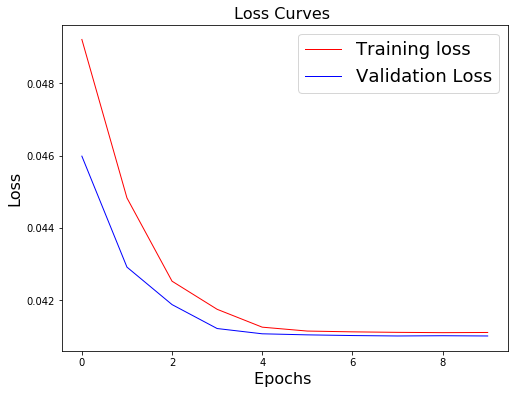

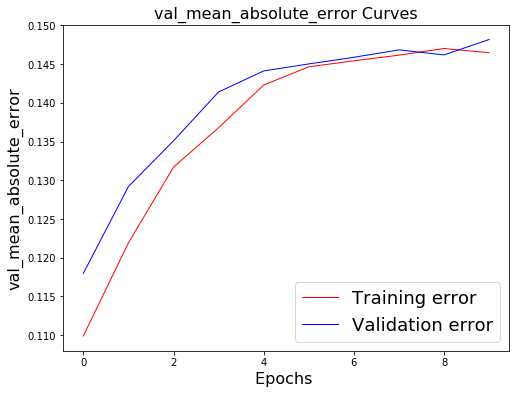

In [39]:
import p7_util

list_model_mae_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

## <font color=blus>3.2. CNN classification model</font>

    Targets, that are real values, are switched to integer, leading to a classification pb.
    For doing that, y_train_encoded and y_test_encoded are transformed as array of integers, 
    ranging from 0 to 10, mean, 11 classes.

In [40]:
import p9_util

nb_classes, y_train_label_encoded = p9_util.y_reg_2_label(y_train_encoded)
_, y_test_label_encoded = p9_util.y_reg_2_label(y_test_encoded)
print("\nNumber of classes issued from one hot encoding= {}".format(nb_classes))


Number of classes issued from one hot encoding= 11


/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

In [41]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dense, Dropout, Embedding, Reshape
from keras.layers.normalization import BatchNormalization


# Each text input will be vecorized as embedding_dim dimensions.
model = Sequential()
#----------------------------------------------------------------
# Convolutional layers
#----------------------------------------------------------------
filter_size=7
strides=6

model.add(Embedding(vocab_size, embedding_dim,input_length=max_length, 
                    weights = [weight_matrix], trainable = False))



model.add(BatchNormalization())
model.add(Conv1D(32, filter_size,padding='same', strides=strides, activation='relu'))

model.add(BatchNormalization())
model.add(Conv1D(32, filter_size,padding='same', strides=strides, activation='relu'))

if True :
    filter_size=9
    strides=8

model.add(BatchNormalization())
model.add(Conv1D(32, filter_size,padding='same', strides=strides, activation='relu'))
#model.add(MaxPooling1D(3))


#----------------------------------------------------------------
# Dense layers
#----------------------------------------------------------------
model.add(Flatten())

#model.add(BatchNormalization())
#model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))


model.add(BatchNormalization())
model.add(Dense(nb_classes, activation='softmax'))


model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 37, 100)           8998400   
_________________________________________________________________
batch_normalization_38 (Batc (None, 37, 100)           400       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 7, 32)             22432     
_________________________________________________________________
batch_normalization_39 (Batc (None, 7, 32)             128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2, 32)             7200      
_________________________________________________________________
batch_normalization_40 (Batc (None, 2, 32)             128       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1, 32)             9248      
__________

In [42]:
import keras
import numpy as np

sgd = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

batch_size = X_train_encoded.shape[0]//10


X_train_reshape = X_train_encoded.reshape(-1, max_length,1)
X_test_reshape = X_test_encoded.reshape(-1, max_length,1)
print(X_train_reshape.shape)
print(X_test_reshape.shape)
print()
print(y_train_label_encoded.shape)
print(y_test_label_encoded.shape)


(273358, 37, 1)
(134465, 37, 1)

(273358, 11)
(134465, 11)


In [46]:
batch_size = X_train_encoded.shape[0]//10
print(batch_size)
print(X_train_encoded.shape,y_train_label_encoded.shape)
print(X_test_encoded.shape,y_test_label_encoded.shape)

27335
(273358, 37) (273358, 11)
(134465, 37) (134465, 11)


In [48]:
history = model.fit(X_train_encoded, y_train_label_encoded, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test_encoded,y_test_label_encoded))

Train on 273358 samples, validate on 134465 samples
Epoch 1/10
273358/273358 [==============================] - 14s 50us/step - loss: 1.6021 - acc: 0.7098 - val_loss: 1.2514 - val_acc: 0.7086
Epoch 2/10
273358/273358 [==============================] - 13s 46us/step - loss: 1.1789 - acc: 0.7098 - val_loss: 1.1394 - val_acc: 0.7086
Epoch 3/10
273358/273358 [==============================] - 14s 51us/step - loss: 1.1418 - acc: 0.7098 - val_loss: 1.1403 - val_acc: 0.7086
Epoch 4/10
273358/273358 [==============================] - 14s 50us/step - loss: 1.1357 - acc: 0.7098 - val_loss: 1.1398 - val_acc: 0.7086
Epoch 5/10
273358/273358 [==============================] - 17s 62us/step - loss: 1.1354 - acc: 0.7098 - val_loss: 1.1542 - val_acc: 0.7086
Epoch 6/10
273358/273358 [==============================] - 16s 59us/step - loss: 1.1408 - acc: 0.7098 - val_loss: 1.1353 - val_acc: 0.7086
Epoch 7/10
273358/273358 [==============================] - 16s 59us/step - loss: 1.1316 - acc: 0.7098 - val

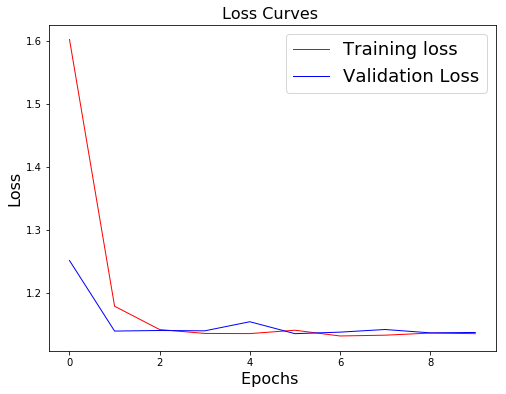

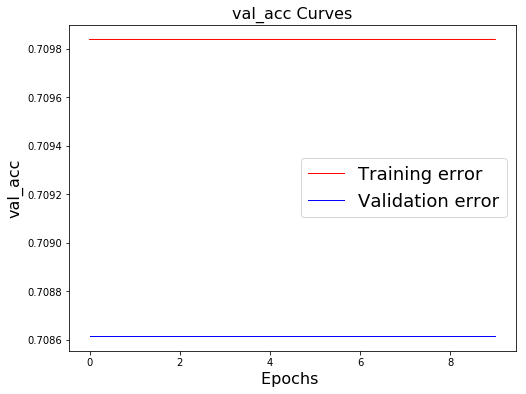

In [49]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)